# PACKAGES AND LIBRARIES

In [240]:
from sklearn.metrics import confusion_matrix, classification_report
from warnings import filterwarnings
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import pandas as pd

In [241]:
filterwarnings("ignore", category=DeprecationWarning) 
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

# Augmentation data

In [242]:
# Define paths
train_directory = Path("Beef/Meat/train")
test_directory = Path("Beef/Meat/test")
valid_directory = Path("Beef/Meat/valid")

In [243]:
# Set the desired sample size
sample_size = 1033

# Set the desired width and height for resizing images
width = 224
height = 224

In [244]:
files = ['Fresh', 'Melted']

def load_images(directory, files, sample_size):
    data = {}
    for f in files:
        data[f] = []

    for col in files:
        dir_path = directory / col
        image_files = [file for file in os.listdir(dir_path) if file.endswith('.jpg')]
        
        # Use all images if fewer than sample_size
        if len(image_files) < sample_size:
            selected_files = image_files
        else:
            selected_files = np.random.choice(image_files, sample_size, replace=False)
        
        for file in selected_files:
            data[col].append(os.path.join(dir_path, file))

    image_data = []
    image_target = []

    for title in files:
        for file in data[title]:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (width, height))
            image_data.append(img_resized)
            image_target.append(title)
    
    return np.array(image_data), np.array(image_target)

# Load and preprocess training data
image_train_data, image_train_target = load_images(train_directory, files, sample_size)
image_test_data, image_test_target = load_images(test_directory, files, sample_size)
image_valid_data, image_valid_target = load_images(valid_directory, files, sample_size)

[WindowsPath('Beef/Meat/train/Fresh/Fresh (1).jpg'), WindowsPath('Beef/Meat/train/Fresh/Fresh (10).jpg'), WindowsPath('Beef/Meat/train/Fresh/Fresh (100).jpg'), WindowsPath('Beef/Meat/train/Fresh/Fresh (1000).jpg'), WindowsPath('Beef/Meat/train/Fresh/Fresh (1001).jpg')]
[WindowsPath('Beef/Meat/test/Fresh/Fresh (1147).jpg'), WindowsPath('Beef/Meat/test/Fresh/Fresh (1148).jpg'), WindowsPath('Beef/Meat/test/Fresh/Fresh (1149).jpg'), WindowsPath('Beef/Meat/test/Fresh/Fresh (1150).jpg'), WindowsPath('Beef/Meat/test/Fresh/Fresh (1151).jpg')]
[WindowsPath('Beef/Meat/valid/Fresh/Fresh (1300).jpg'), WindowsPath('Beef/Meat/valid/Fresh/Fresh (1301).jpg'), WindowsPath('Beef/Meat/valid/Fresh/Fresh (1302).jpg'), WindowsPath('Beef/Meat/valid/Fresh/Fresh (1303).jpg'), WindowsPath('Beef/Meat/valid/Fresh/Fresh (1304).jpg')]


In [245]:
# Verify loaded data
print(f"Training data shape: {image_train_data.shape}")
print(f"Training labels shape: {image_train_target.shape}")
print(f"Test data shape: {image_test_data.shape}")
print(f"Test labels shape: {image_test_target.shape}")
print(f"Validation data shape: {image_valid_data.shape}")
print(f"Validation labels shape: {image_valid_target.shape}")

In [246]:
# Plot the data distribution
sizes = [len(image_train_target[image_train_target == 'Fresh']), len(image_train_target[image_train_target == 'Melted'])]

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color':"w", "fontsize":15}, startangle=90, explode=(0, .01))
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [247]:
# Define size_train to be the length of image_train_data
size_train = len(image_train_data)

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.randint(size_train)
    plt.subplot(4, 4, i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig] == 'Fresh':
        c = 'green'
    else:
        c = 'red'
    plt.title(image_train_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [248]:
from sklearn.preprocessing import LabelEncoder

In [249]:
labels = LabelEncoder()
labels.fit(image_train_target)

In [250]:
# Normalize the images
X_train = image_train_data / 255.0
X_test = image_test_data / 255.0
X_valid = image_valid_data / 255.0

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(image_train_target)
y_test = label_encoder.transform(image_test_target)
y_valid = label_encoder.transform(image_valid_target)

# Memeriksa ukuran set
print(f"Train set size: {y_train.shape[0]}")
print(f"Validation set size: {y_valid.shape[0]}")
print(f"Test set size: {y_test.shape[0]}")

# Split Data

In [251]:

# Assuming y_train and y_valid are integer labels (e.g., 0 or 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=2)

Train set size: 2066
Validation set size: 452
Test set size: 452
Index(['JPG', 'CATEGORY'], dtype='object')
Index(['JPG', 'CATEGORY'], dtype='object')
Index(['JPG', 'CATEGORY'], dtype='object')


# Inception V3 model
keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

Arguments

- include_top: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Defaults to True.
weights: One of None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to "imagenet".

- input_tensor: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. input_tensor is useful for sharing inputs between multiple different networks. Defaults to None.

- input_shape: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) (with channels_last data format) or (3, 299, 299) (with channels_first data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75. E.g. (150, 150, 3) would be one valid value. input_shape will be ignored if the input_tensor is provided.

- pooling: Optional pooling mode for feature extraction when include_top is False.
None (default) means that the output of the model will be the 4D tensor output of the last convolutional block.
avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
max means that global max pooling will be applied.

- classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Defaults to 1000.

- classifier_activation: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

Returns
- A model instance.

Documentation at https://keras.io/api/applications/inceptionv3/

In [255]:
# Load the pretrained model without the top layer
pretrained_model3 = tf.keras.applications.InceptionV3(input_shape=(224, 224 ,3), include_top=False, weights=None)
pretrained_model3.trainable = False

In [256]:
# Add new layers
x3 = pretrained_model3.output
x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)  # Use GlobalAveragePooling2D to reduce dimensions
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)

# Define the model
model = tf.keras.Model(inputs=pretrained_model3.input, outputs=outputs3)

In [257]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [258]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Call_Back = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99:
            print("\nReached or exceeded 99.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [259]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    verbose=1,
    callbacks=[Call_Back, model_checkpoint, callback]
)

Epoch 1/50
65/65 [==============================] - 67s 968ms/step - loss: 0.4700 - accuracy: 0.8804 - val_loss: 0.7582 - val_accuracy: 0.5000
Epoch 2/50
65/65 [==============================] - 57s 877ms/step - loss: 0.2121 - accuracy: 0.9463 - val_loss: 0.6196 - val_accuracy: 0.5199
Epoch 3/50
65/65 [==============================] - 56s 859ms/step - loss: 0.1542 - accuracy: 0.9472 - val_loss: 0.5337 - val_accuracy: 0.8761
Epoch 4/50
65/65 [==============================] - 55s 851ms/step - loss: 0.1513 - accuracy: 0.9545 - val_loss: 1.1930 - val_accuracy: 0.5000
Epoch 5/50
65/65 [==============================] - 56s 859ms/step - loss: 0.1184 - accuracy: 0.9608 - val_loss: 0.3728 - val_accuracy: 0.9403
Epoch 6/50
65/65 [==============================] - 59s 914ms/step - loss: 0.1164 - accuracy: 0.9593 - val_loss: 0.5309 - val_accuracy: 0.5465
Epoch 7/50
65/65 [==============================] - 63s 970ms/step - loss: 0.1159 - accuracy: 0.9656 - val_loss: 0.5872 - val_accuracy: 0.5487

In [260]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

15/15 [==============================] - 8s 504ms/step - loss: 0.4063 - accuracy: 0.9403
LOSS:  0.4063
ACCURACY:  0.94


In [261]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

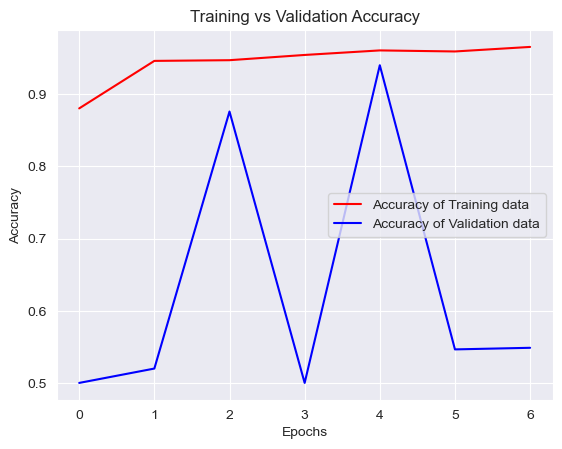

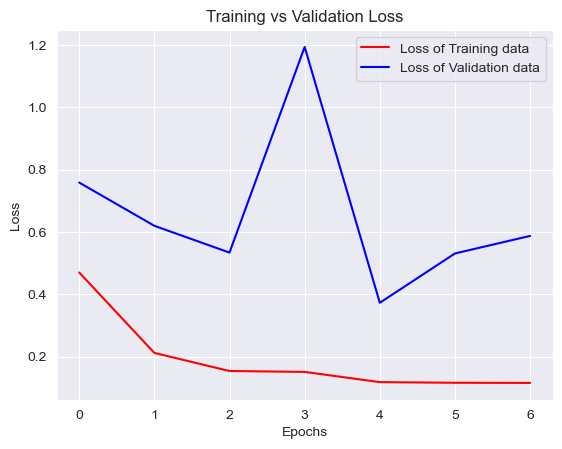

In [262]:
result=model.evaluate(X_test, y_test)

In [263]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

15/15 [==============================] - 9s 504ms/step
['Fresh', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted', 'Fresh', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted']


In [264]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [265]:
# Prediksi pada data validasi
y_val_pred = model.predict(X_valid)

# Definisi fungsi untuk mengkonversi prediksi ke kelas
def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_

# Membuat confusion matrix untuk data validasi
cm_val = confusion_matrix(y_valid, toClass(y_val_pred))

df_val = pd.DataFrame(columns=["Fresh", "Melted"], index=["Fresh", "Melted"], data=cm_val)

f_val, ax_val = plt.subplots(figsize=(6, 6))
sns.heatmap(df_val, annot=True, cmap="Greens", fmt='.0f', ax=ax_val, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.ylabel("True Label")
plt.title("Validation Confusion Matrix", size=12)
plt.show()

              precision    recall  f1-score   support

       Fresh       0.93      0.95      0.94       226
      Melted       0.95      0.93      0.94       226

    accuracy                           0.94       452
   macro avg       0.94      0.94      0.94       452
weighted avg       0.94      0.94      0.94       452


Confusion Matrix:
[[214  12]
 [ 15 211]]


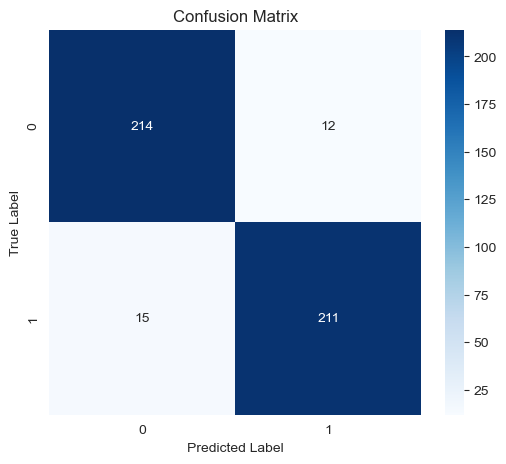

In [266]:
y_pred = model.predict(X_test)

def toClass(pred):
    
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
        
    return class_

cm = confusion_matrix(y_test,toClass(y_pred))

df1 = pd.DataFrame(columns=["Fresh","Melted"], index= ["Fresh","Melted"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

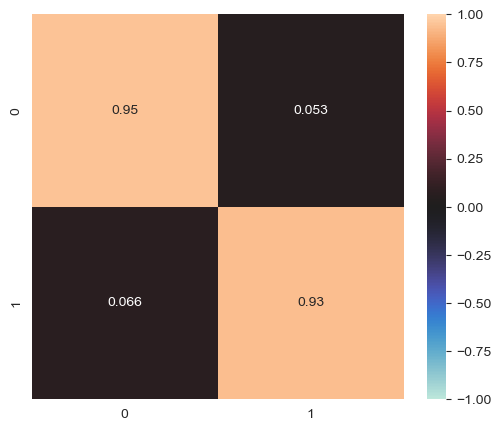

In [267]:
from sklearn.metrics import classification_report

# Prediksi kelas untuk data uji
y_pred_class = toClass(y_pred)

# Buat classification report
report = classification_report(y_test, y_pred_class, target_names=files)

# Tampilkan classification report
print("Classification Report:")
print(report)


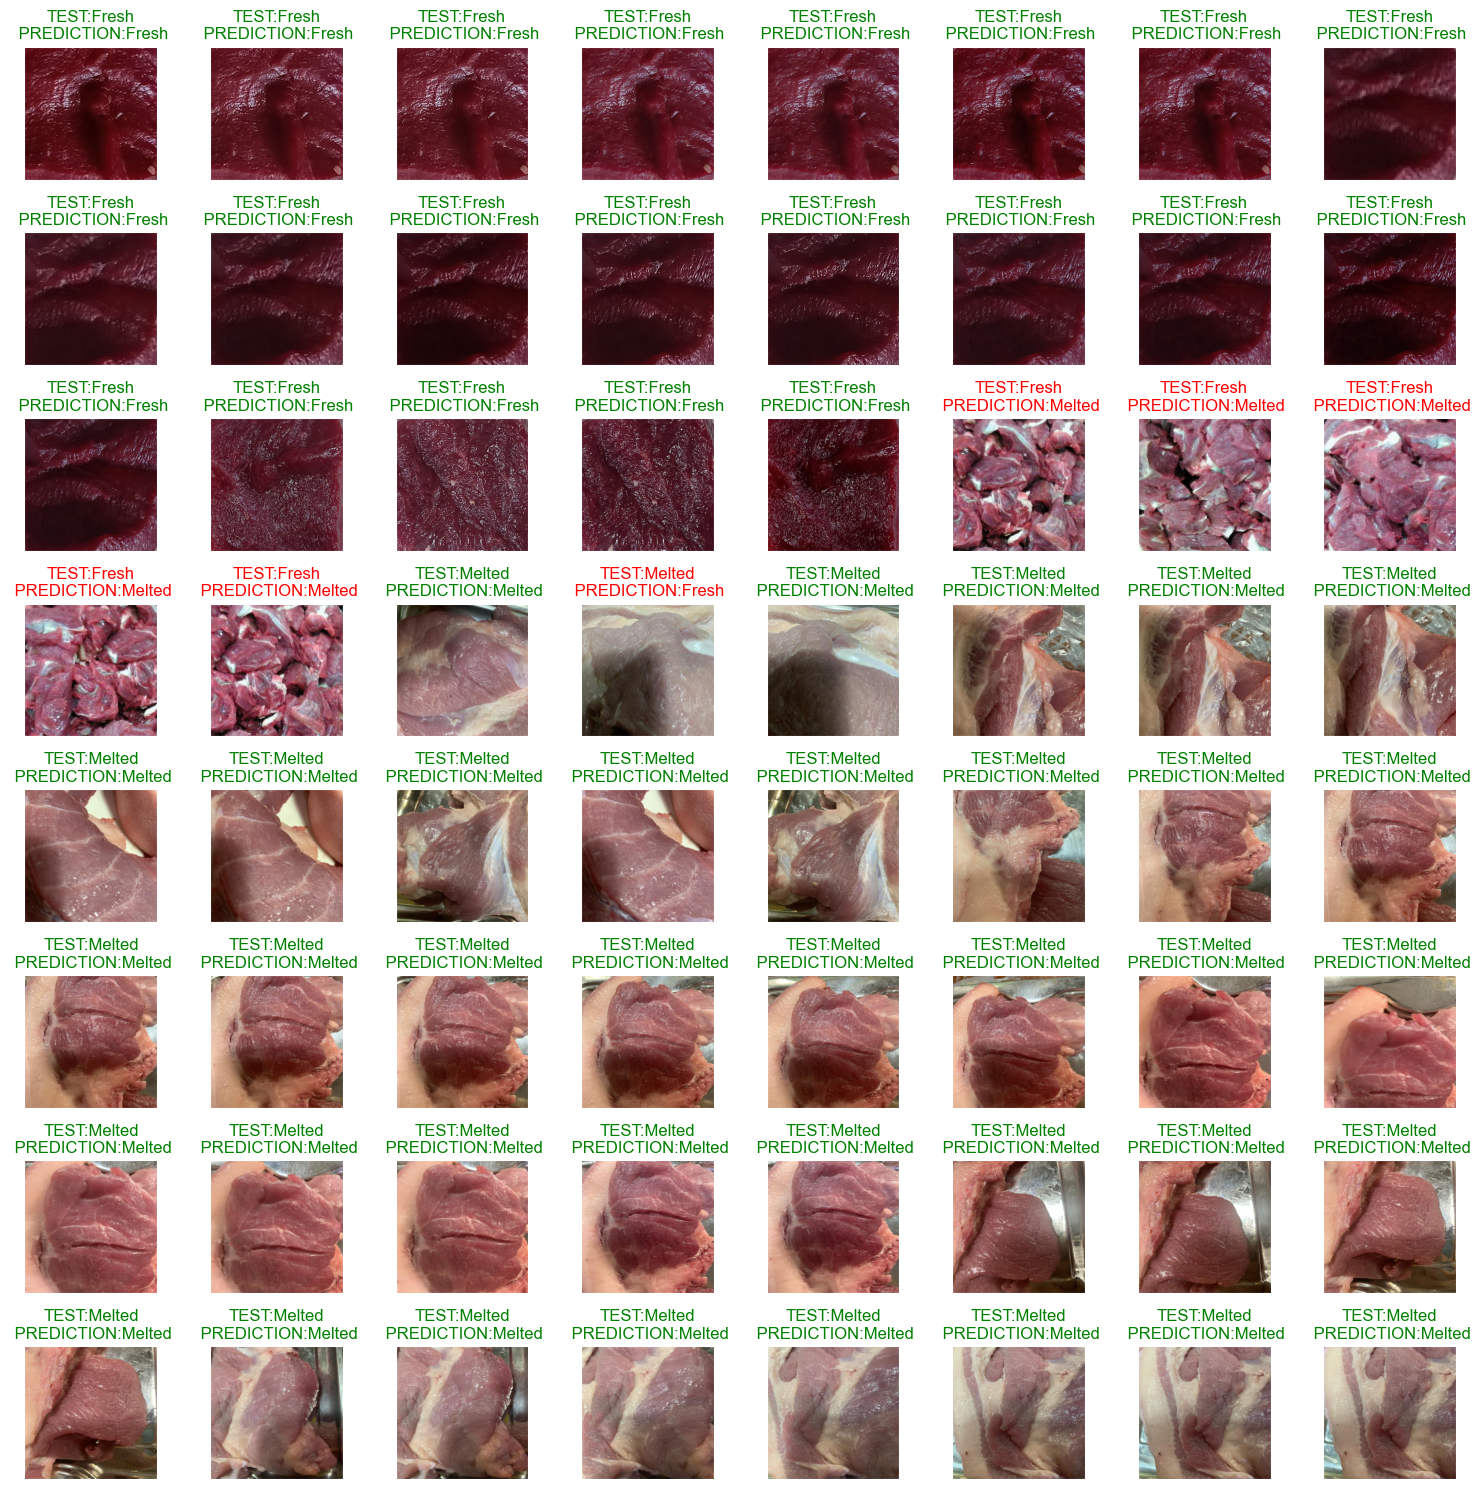

In [268]:
def prediction(image):
    
    global width, height, files, labels
    
    img = cv2.resize(image,(width,height))
    
    test = img / 255.0
    
    pred = model.predict(np.array([image])).argmax()
    
    return labels.inverse_transform([pred])[0]

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,26):
    fig = np.random.choice(np.arange(size_train))
    plt.subplot(5,5,i)
    plt.imshow(image_train_data[fig])
    if image_train_target[fig]=='Fresh':
        c='green'
    else:
        c='red'
    plt.title(image_train_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(prediction(image_train_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()